# Coin Toss with ADVI Ajax

In [1]:
try:
  from ajax import ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import train
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from functools import partial 
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
url = 'https://raw.githubusercontent.com/AnandShegde/pml_baselines/main/data/coin_toss/coin_toss'
data = pd.read_pickle(url)

dataset = data['data']
alpha_param = data['prior'] ['alpha']
beta_param = data['prior']['beta']

## Defining model with ajax

In [3]:
prior = {
    "theta" : tfd.Beta(alpha_param, beta_param)
}

bijectors = {
    "theta" : tfb.Sigmoid()
}

def get_log_likelihood(params, aux, data, **kwargs):
    probs = params["theta"]
    likelihood = tfd.Bernoulli(probs = probs)
    return likelihood.log_prob(data).sum()

model = ADVI(prior, bijectors, get_log_likelihood, vi_type = "full_rank")

## Training the model

Text(0, 0.5, 'loss')

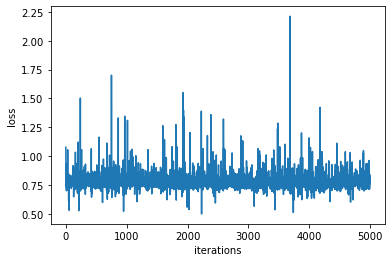

In [12]:
optimizer = optax.adam(learning_rate=0.1)
epochs = 5000
seed = jax.random.PRNGKey(10)
params = model.init(seed)

loss_fn = partial(model.loss_fn,batch = dataset,  data_size = len(dataset), aux = {}, n_samples = 1)
model_params = train(loss_fn, params, optimizer = optimizer, n_epochs = epochs, seed = jax.random.PRNGKey(10),return_args = ["losses"])

plt.plot(model_params["losses"])
plt.xlabel("iterations")
plt.ylabel("loss")

## PLotting the results

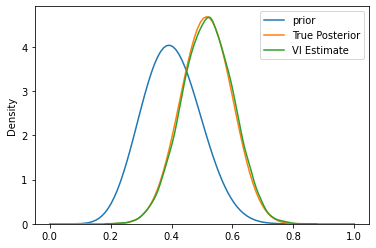

In [13]:
beta_dist_one = tfd.Beta(alpha_param, beta_param)
x = jnp.linspace(0,1,100)
plt.plot(x,beta_dist_one.prob(x),label="prior")

one= jnp.sum(dataset==1).astype('float32')
zero= jnp.sum(dataset==0).astype('float32')
beta_dist = tfd.Beta(alpha_param+one, beta_param+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")

posterior = model.apply(model_params["params"])
samples = posterior.sample(seed = jax.random.PRNGKey(9),sample_shape = (10000,))
sns.kdeplot(samples["theta"],label = "VI Estimate")
plt.legend()

In [14]:
with open("../results/coin_toss/results_data/coin_toss_VI_Ajax_result",'wb') as f:
    pickle.dump(posterior, f,protocol = 1)